#### USA Houseprices - Excercise 1 - Timothy Gregorian

In this analysis, we explore a dataset of housing prices in the United States to understand the key factors that influence property values. The main goal is to build a predictive model using a deep learning neural network, which can accurately estimate house prices based on their characteristics.

In addition, we will analyze the correlations between the variables, since there is a possibility that the dataset may not be suitable for achieving a high R-squared score when evaluating the quality of the model.

### Link to Dataset 1
https://www.kaggle.com/datasets/arnavgupta1205/usa-housing-dataset

### Information about the Dataset
This USA Housing Market Dataset contains 300 rows and 10 columns of real-estate related data, which can be used for housing price predictions.

### Data Description
The dataset consists of 10 variables related  to housing characteristics in the United States:

1) Price: The selling price of the house (target variable).

2) Bedrooms: Number of bedrooms in the house.

3) Bathrooms: Number of bathrooms in the house.

4) SquareFeet: Total living area in square feet.

5) YearBuilt: The year the property was constructed.

6) GarageSpaces: Number of garage spaces available.

7) LotSize: Size of the property lot.

8) ZipCode: Postal code indicating the geographical location of the    house (categorical variable).

9) CrimeRate: Crime index of the neighborhood where the house is located (0.0 - 100.0).

10) SchoolRating: Quality rating of nearby schools, ranging from 1 (lowest) to 10 (highest).

#### Import all necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import tensorflow as tf
import keras
from keras import layers

#### Load the Dataset

In [3]:
df = pd.read_csv("usa_housing_kaggle.csv")
df.head()

,Price,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,ZipCode,CrimeRate,SchoolRating
0,221958,1,1.9,4827,1979,2,1.45,82240,48.60,5
1,771155,2,2.0,1035,1987,2,1.75,74315,92.03,9
2,231932,1,3.0,2769,1982,1,1.46,79249,52.08,3
3,465838,3,3.3,2708,1907,3,1.62,80587,61.65,1
4,359178,4,3.4,1175,1994,2,0.74,20756,15.66,4


#### Information about the Dataset

In [4]:
print(df.shape)
print("\n")
print(df.info())
print("\n")
print(df.describe())

(300, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         300 non-null    int64  
 1   Bedrooms      300 non-null    int64  
 2   Bathrooms     300 non-null    float64
 3   SquareFeet    300 non-null    int64  
 4   YearBuilt     300 non-null    int64  
 5   GarageSpaces  300 non-null    int64  
 6   LotSize       300 non-null    float64
 7   ZipCode       300 non-null    int64  
 8   CrimeRate     300 non-null    float64
 9   SchoolRating  300 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 23.6 KB
None


               Price    Bedrooms   Bathrooms  SquareFeet    YearBuilt  \
count     300.000000  300.000000  300.000000   300.00000   300.000000   
mean   522761.916667    2.966667    2.464000  3052.75000  1962.616667   
std    256922.348275    1.451175    0.886184  1194.97144    36.005431   
min    112666.000

#### Check the length of the Dataset

In [5]:
print("Amount of data in the dataset: ")
len(df)

Amount of data in the dataset: 


300

#### Check for any missing values 

In [6]:
df.isna().sum()

Price           0
Bedrooms        0
Bathrooms       0
SquareFeet      0
YearBuilt       0
GarageSpaces    0
LotSize         0
ZipCode         0
CrimeRate       0
SchoolRating    0
dtype: int64

#### Check for any duplicates

In [7]:
print("Duplicates: ")
duplicates = int(df.duplicated().sum())
duplicates

Duplicates: 


0

#### Data Cleaning 
The results showed that the dataset contains 300 observations, with no missing values and no duplicate records.

In [9]:
# Independent Variable List:
# Bedrooms
# Bathrooms
# Squarefeet
# YearBuilt
# GarageSpaces
# LotSize
# ZipCode
# CrimeRate
# SchoolRating

# Dependent Variables:
# Price -> Training the model to predict this variable
# Save every independent variable in X, except for "price"

def zipcode_to_region(zipcode):
    if 10000 <= zipcode < 30000:
        return "East"
    elif 30000 <= zipcode < 50000:
        return "South"
    elif 50000 <= zipcode < 70000:
        return "North"
    else:
        return "West"

# Falls Region-Spalten schon da sind → löschen
df = df.drop(columns=["Region_East", "Region_West", "Region_South", "Region_North"], errors="ignore")

# Neue Spalte mit Regionen
df["Region"] = df["ZipCode"].apply(zipcode_to_region)

# One-Hot-Encoding für Regionen
df = pd.get_dummies(df, columns=["Region"], drop_first=False)

# X/y -Split
y = df["Price"]
X = df.drop(["Price", "ZipCode"], axis=1)

#### Correlation

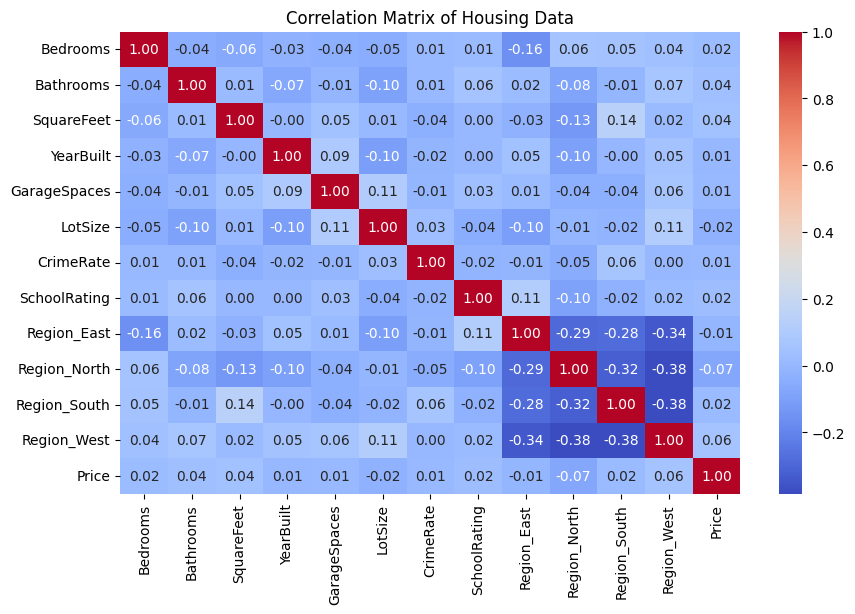

In [10]:
# Correlation Matrix
corr = X.join(y).corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Housing Data")
plt.show()

#### Fisher Score

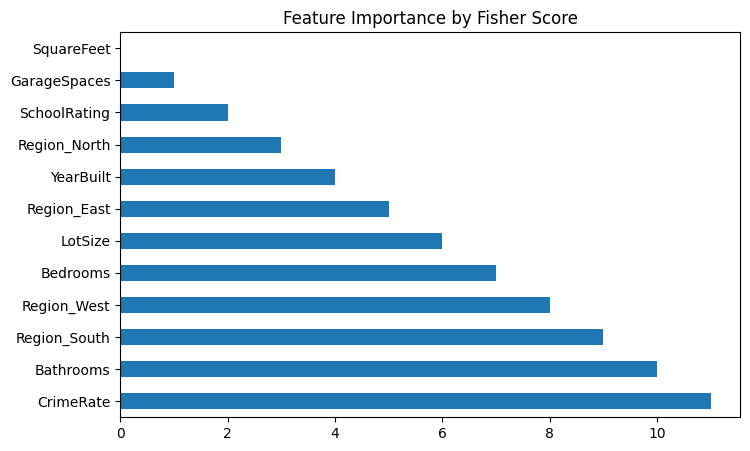

In [12]:
from skfeature.function.similarity_based import fisher_score

# Price in Kategorien (Quartile) aufteilen
y_binned = pd.qcut(y, q=4, labels=False)

# Fisher Score berechnen
ranks = fisher_score.fisher_score(X.values, y_binned.values)
feat_importances = pd.Series(ranks, index=X.columns)

# Sortieren & Plotten
feat_importances.sort_values(ascending=False).plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance by Fisher Score")
plt.show()



#### SelectKBest-Score

In [13]:
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np

# Chi² Test erwartet nur nicht-negative Werte
X_cat = np.abs(X)  
y_cat = y.astype(int)

chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_cat, y_cat)

chi2_scores = pd.DataFrame({
    "Feature": X_cat.columns,
    "Chi2 Score": chi2_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print(chi2_scores)


         Feature     Chi2 Score
2     SquareFeet  139860.475391
6      CrimeRate    5039.632897
7   SchoolRating     419.528450
4   GarageSpaces     246.440529
8    Region_East     239.000000
10  Region_South     228.000000
9   Region_North     227.000000
0       Bedrooms     212.247191
11   Region_West     206.000000
3      YearBuilt     197.502102
1      Bathrooms      95.296753
5        LotSize      83.271463


#### VIF-Test

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Kopie nur mit numerischen Features
X_vif = X.copy()

# sicherstellen, dass alle Features float sind
X_vif = X_vif.astype(float)

# DataFrame für VIF-Ergebnisse
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)


         Feature          VIF
0       Bedrooms     1.040308
1      Bathrooms     1.033074
2     SquareFeet     1.039447
3      YearBuilt     1.042271
4   GarageSpaces     1.030404
5        LotSize     1.062858
6      CrimeRate     1.009585
7   SchoolRating     1.023965
8    Region_East   652.689179
9   Region_North   773.774603
10  Region_South   769.372113
11   Region_West  1007.981243


#### X/y -Split

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Training size: (210, 12)
Validation size: (45, 12)
Test size: (45, 12)


#### Scaling of the Data

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialisiere den Scaler
scaler = StandardScaler()

# Fit nur mit Trainingsdaten, dann transformiere alle Sets
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

#### Architecture of the neural network

In [19]:
variable_amount = len(X.columns)

training_model_1 = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)

training_model_1.compile(optimizer="adam", loss="mse")

training_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,137 (4.44 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 24 (96.00 B)

#### Training of the model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",  # überwacht den Validierungsfehler
    patience=20,         # wenn 20 Epochen lang keine Verbesserung → Stop
    restore_best_weights=True
)

history = training_model_1.fit(
    x=X_train, y=y_train,
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 353811005440.0000 - val_loss: 312602001408.0000
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 353810710528.0000 - val_loss: 312601706496.0000
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 353810382848.0000 - val_loss: 312601411584.0000
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 353810087936.0000 - val_loss: 312601116672.0000
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 353809793024.0000 - val_loss: 312600821760.0000
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 353809432576.0000 - val_loss: 312600428544.0000
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 353809039360.0000 - val_loss: 312600002560.0000
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 353808515072.0000 - val_loss: 312599445504.0000
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 353807925248.0000 - val_loss: 312598822912.0000
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

#### Visualisation of the results

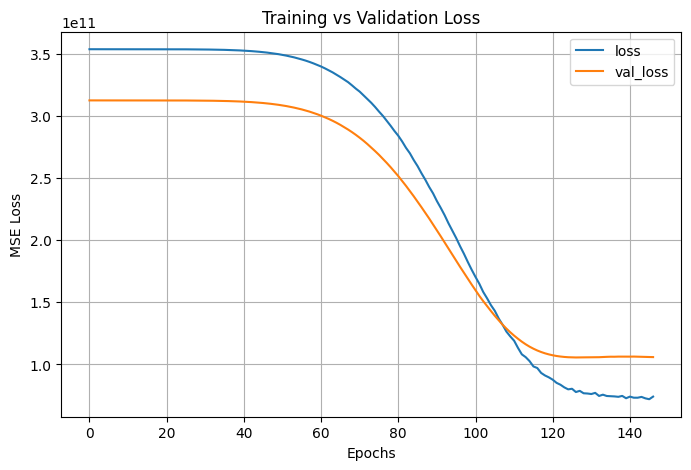

In [22]:
loss_df = pd.DataFrame(training_model_1.history.history)
loss_df.plot(figsize=(8,5))
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


#### Data evaluation

In [23]:
print("Test data evaluation")
print(training_model_1.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(training_model_1.evaluate(X_train, y_train, verbose=0))

Test data evaluation
77341777920.0

Train data evaluation:
78403256320.0


#### Prediction of the data

In [26]:
import seaborn as sns

test_predictions = training_model_1.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))

pred_df = pd.DataFrame(pd.DataFrame(np.asarray(y_test), columns=["Test True Y"]))
pred_df = pd.concat([pred_df, test_predictions], axis = 1)
pred_df.columns = ["Test True Y", "Model Predictions"]

pred_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


,Test True Y,Model Predictions
0,291335,292249.968750
1,455528,486351.312500
2,867595,438202.562500
3,151663,488196.125000
4,819094,479485.625000
5,374329,462338.812500
6,827270,609689.750000
7,206530,450338.937500
8,979858,301795.875000
9,236330,660656.937500


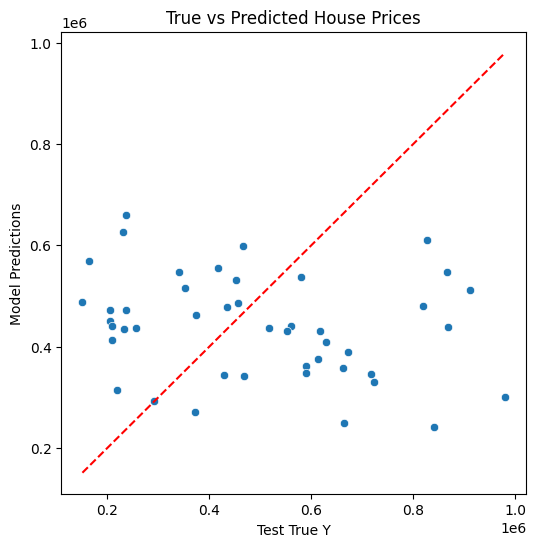

In [38]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="Test True Y", y="Model Predictions", data=pred_df)

# Rote gestrichelte Linie (perfekte Vorhersage)
min_val = min(pred_df["Test True Y"].min(), pred_df["Model Predictions"].min())
max_val = max(pred_df["Test True Y"].max(), pred_df["Model Predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.title("True vs Predicted House Prices")
plt.xlabel("Test True Y")
plt.ylabel("Model Predictions")
plt.show()


In [39]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
236215.02 $

MSE
77341777920.0 $^2

RMSE:
278103.9 $

R-squared:
-0.46

Explained variance score:
-0.41


C:\Users\Timothy\AppData\Local\Temp\ipykernel_4008\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


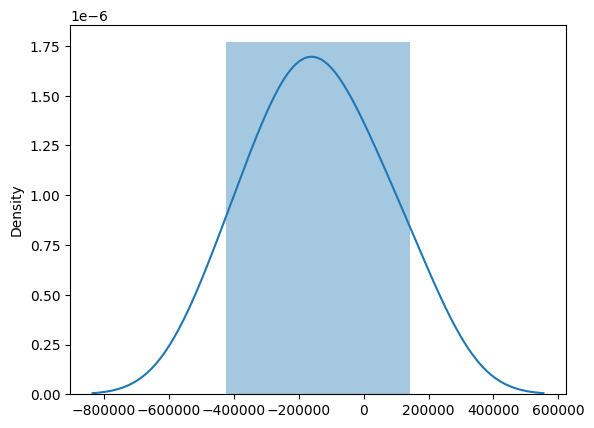

In [40]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

#### Trying the model in practice with new imaginery house

In [44]:
X.columns

Index(['Bedrooms', 'Bathrooms', 'SquareFeet', 'YearBuilt', 'GarageSpaces',
       'LotSize', 'CrimeRate', 'SchoolRating', 'Region_East', 'Region_North',
       'Region_South', 'Region_West'],
      dtype='object')

In [45]:
X.head(3)

,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,CrimeRate,SchoolRating,Region_East,Region_North,Region_South,Region_West
0,1,1.9,4827,1979,2,1.45,48.60,5,False,False,False,True
1,2,2.0,1035,1987,2,1.75,92.03,9,False,False,False,True
2,1,3.0,2769,1982,1,1.46,52.08,3,False,False,False,True


In [48]:
tester_row = {
    "Bedrooms": 4,
    "Bathrooms": 3,
    "SquareFeet": 2500,
    "YearBuilt": 2010,
    "GarageSpaces": 2,
    "LotSize": 5000,
    "CrimeRate": 0.05,
    "SchoolRating": 8,
    "Region_East": 0,
    "Region_North": 1,
    "Region_South": 0,
    "Region_West": 0
}

# In ein DataFrame umwandeln
tester_row = pd.DataFrame([tester_row])

# WICHTIG: Die gleichen Transformationen anwenden wie beim Training
tester_row_scaled = scaler.transform(tester_row)

# Vorhersage machen
result = training_model_1.predict(tester_row_scaled)[0][0]

print("Estimated house price with this example:")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Estimated house price with this example:
$217651248.0


#### Conclusion
The analysis highlights several challenges in predicting house prices with our dataset using a neural network:

Correlations: Most features show only very weak correlations with the target variable (Price). This limits the model’s ability to learn strong predictive patterns.

Feature Importance (Fisher Score & Chi²): Variables such as SquareFeet, CrimeRate, and Region have higher importance, while others contribute very little. This confirms that not all features are equally useful.

VIF Test: The results reveal high multicollinearity among the Region variables, meaning that some of them are redundant and may confuse the model.

Model Performance: The error metrics (MAE, RMSE, negative R²) show that the trained model currently performs poorly. Predictions on new test data are also far off from the true values.

In the end, the weak performance is less a problem of the neural network architecture itself, but rather of the dataset. The low correlation make accurate prediction difficult. To improve results, a larger and higher-quality dataset with more meaningful features would be necessary.

#### Use of AI
Since the original dataset was relatively small and might have limited the model’s learning capacity, I used AI to generate 5,000 synthetic but realistic housing data samples. The goal was to test whether the poor performance mainly resulted from the lack of data. By expanding the dataset, we aimed to give the model more diverse examples and improve its ability to generalize.

#### Loading the dataset

In [55]:
# No categorial variables, only numerical values
df = pd.read_csv("usa_housing_realistic.csv")
df.head()

,Price,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,ZipCode,CrimeRate,SchoolRating
0,768057,4,1.7,2847,1972,2,1.46,75201,37.28,10
1,712254,5,3.3,2740,1964,1,1.66,30301,39.89,1
2,713762,3,2.4,3163,1966,2,0.99,30301,84.57,3
3,881840,5,2.7,3306,1963,2,1.29,60601,49.06,5
4,881072,5,2.9,3591,1965,1,1.54,30301,53.41,4


In [56]:
print(df.shape)
print("\n")
print(df.info())
print("\n")
print(df.describe())

(5000, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         5000 non-null   int64  
 1   Bedrooms      5000 non-null   int64  
 2   Bathrooms     5000 non-null   float64
 3   SquareFeet    5000 non-null   int64  
 4   YearBuilt     5000 non-null   int64  
 5   GarageSpaces  5000 non-null   int64  
 6   LotSize       5000 non-null   float64
 7   ZipCode       5000 non-null   int64  
 8   CrimeRate     5000 non-null   float64
 9   SchoolRating  5000 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 390.8 KB
None


              Price     Bedrooms    Bathrooms   SquareFeet    YearBuilt  \
count  5.000000e+03  5000.000000  5000.000000  5000.000000  5000.000000   
mean   6.907359e+05     3.010800     2.890500  2704.120200  1985.472200   
std    1.835829e+05     1.424601     0.661585   746.768298    21.087384   
min  

In [57]:
print("Amount of data in the dataset: ")
len(df)

Amount of data in the dataset: 


5000

#### Clean the dataset and handle mising values

In [58]:
df.isna().sum()

Price           0
Bedrooms        0
Bathrooms       0
SquareFeet      0
YearBuilt       0
GarageSpaces    0
LotSize         0
ZipCode         0
CrimeRate       0
SchoolRating    0
dtype: int64

#### Check if there are any duplicates

In [59]:
print("Duplicates: ")
duplicates = int(df.duplicated().sum())
duplicates

Duplicates: 


0

In [60]:
# Independent Variable List:
# Bedrooms
# Bathrooms
# Squarefeet
# YearBuilt
# GarageSpaces
# LotSize
# ZipCode
# CrimeRate
# SchoolRating

# Dependent Variables:
# Price -> Training the model to predict this variable
# Save every independent variable in X, except for "price"

def zipcode_to_region(zipcode):
    if 10000 <= zipcode < 30000:
        return "East"
    elif 30000 <= zipcode < 50000:
        return "South"
    elif 50000 <= zipcode < 70000:
        return "North"
    else:
        return "West"

# Falls Region-Spalten schon da sind → löschen
df = df.drop(columns=["Region_East", "Region_West", "Region_South", "Region_North"], errors="ignore")

# Neue Spalte mit Regionen
df["Region"] = df["ZipCode"].apply(zipcode_to_region)

# One-Hot-Encoding für Regionen
df = pd.get_dummies(df, columns=["Region"], drop_first=False)

# X/y -Split
y = df["Price"]
X = df.drop(["Price", "ZipCode"], axis=1)

#### Correlation

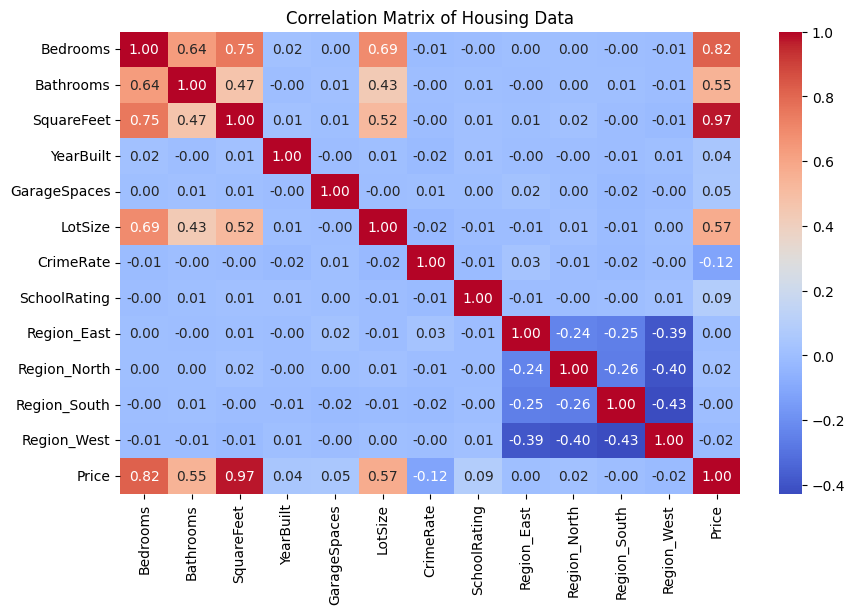

In [61]:
# Correlation Matrix
corr = X.join(y).corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Housing Data")
plt.show()

#### Fisher-Score

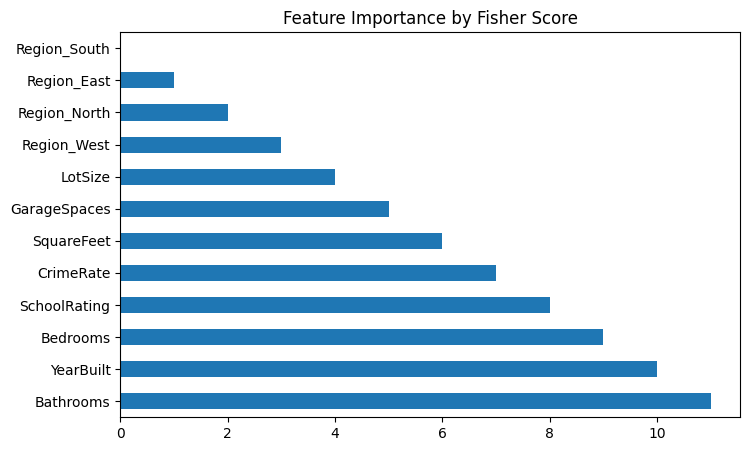

In [62]:
from skfeature.function.similarity_based import fisher_score

# Price in Kategorien (Quartile) aufteilen
y_binned = pd.qcut(y, q=4, labels=False)

# Fisher Score berechnen
ranks = fisher_score.fisher_score(X.values, y_binned.values)
feat_importances = pd.Series(ranks, index=X.columns)

# Sortieren & Plotten
feat_importances.sort_values(ascending=False).plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance by Fisher Score")
plt.show()

#### SelectKBest-Score

In [63]:
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np

# Chi² Test erwartet nur nicht-negative Werte
X_cat = np.abs(X)  
y_cat = y.astype(int)

chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_cat, y_cat)

chi2_scores = pd.DataFrame({
    "Feature": X_cat.columns,
    "Chi2 Score": chi2_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print(chi2_scores)

         Feature    Chi2 Score
2     SquareFeet  1.030823e+06
6      CrimeRate  3.911576e+04
7   SchoolRating  7.296236e+03
8    Region_East  4.040463e+03
9   Region_North  3.997633e+03
10  Region_South  3.911387e+03
0       Bedrooms  3.365855e+03
11   Region_West  3.007443e+03
4   GarageSpaces  2.167729e+03
3      YearBuilt  1.115821e+03
5        LotSize  7.609664e+02
1      Bathrooms  7.556214e+02


d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  self.y_type_ = type_of_target(y, input_name="y")
d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\sklearn\preprocessing\_label.py:359: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_is_multilabel = type_of_target(y).startswith("multilabel")
d:\5. Semester\Deep Learning\DL-projects\venv312\Li

#### VIF-Test

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Kopie nur mit numerischen Features
X_vif = X.copy()

# sicherstellen, dass alle Features float sind
X_vif = X_vif.astype(float)

# DataFrame für VIF-Ergebnisse
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

         Feature          VIF
0       Bedrooms     3.930642
1      Bathrooms     1.686300
2     SquareFeet     2.297704
3      YearBuilt     1.001190
4   GarageSpaces     1.000970
5        LotSize     1.903355
6      CrimeRate     1.002097
7   SchoolRating     1.000972
8    Region_East  1697.028720
9   Region_North  1755.826894
10  Region_South  1937.604167
11   Region_West  3549.056924


#### X/y -Split

In [65]:
# Data splitted into 70% training data and 30% temporary data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# Temporary data splitted into 15% test data and 15% validation data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Training size: (3500, 12)
Validation size: (750, 12)
Test size: (750, 12)


#### Scaling of the Data

In [66]:
from sklearn.preprocessing import StandardScaler

# Initialisiere den Scaler
scaler = StandardScaler()

# Fit nur mit Trainingsdaten, dann transformiere alle Sets
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


#### Create a neural network structure

In [67]:
variable_amount = len(X.columns)

training_model_2 = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1)
    ]
)

training_model_2.compile(optimizer="adam", loss="mse")

training_model_2.summary()

d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 409 (1.60 KB)

 Non-trainable params: 24 (96.00 B)

#### Train the neural network

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",  # überwacht den Validierungsfehler
    patience=20,         # wenn 20 Epochen lang keine Verbesserung → Stop
    restore_best_weights=True
)

history = training_model_2.fit(
    x=X_train, y=y_train,
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 505936510976.0000 - val_loss: 523007754240.0000
Epoch 2/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 505925926912.0000 - val_loss: 522974756864.0000
Epoch 3/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 505793118208.0000 - val_loss: 522606968832.0000
Epoch 4/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 504786780160.0000 - val_loss: 520407711744.0000
Epoch 5/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 500613644288.0000 - val_loss: 513017544704.0000
Epoch 6/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 489136324608.0000 - val_loss: 495131033600.0000
Epoch 7/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 464806084608.0000 - val_loss: 460608339968.0000
Epoch 8/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 421775081472.0000 - val_loss: 404486062080.0000
Epoch 9/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 356518854656.0000 - val_loss: 324959961088.0000
Epoch 10/300
110/11

#### Performance and Error Metrics

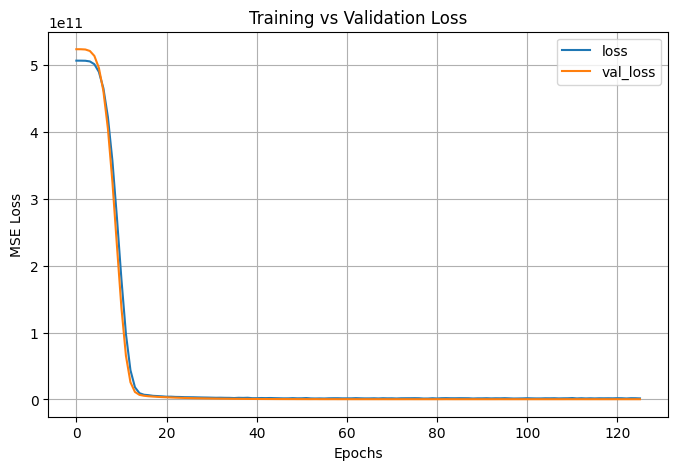

In [69]:
loss_df = pd.DataFrame(training_model_2.history.history)
loss_df.plot(figsize=(8,5))
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

#### Trying the model and predict the price with new house data

In [70]:
print("Test data evaluation")
print(training_model_2.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(training_model_2.evaluate(X_train, y_train, verbose=0))

Test data evaluation
416595968.0

Train data evaluation:
386676032.0


In [71]:
import seaborn as sns

# Predictions für Testdaten
test_predictions = training_model_2.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))

# DataFrame mit echten & predicted Werten
pred_df = pd.DataFrame(pd.DataFrame(np.asarray(y_test), columns=["Test True Y"]))
pred_df = pd.concat([pred_df, test_predictions], axis = 1)
pred_df.columns = ["Test True Y", "Model Predictions"]

pred_df

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Test True Y,Model Predictions
0,569531,573869.7500
1,895561,870973.8750
2,826691,848684.6250
3,492147,472027.6250
4,625516,635556.8750
...,...,...
745,541866,561947.7500
746,598411,618247.7500
747,588091,587266.8750
748,942580,966327.3125


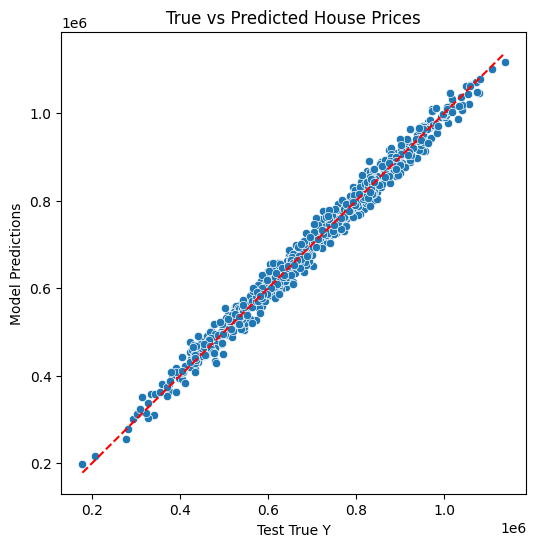

In [72]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="Test True Y", y="Model Predictions", data=pred_df)

# Rote gestrichelte Linie (perfekte Vorhersage)
min_val = min(pred_df["Test True Y"].min(), pred_df["Model Predictions"].min())
max_val = max(pred_df["Test True Y"].max(), pred_df["Model Predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.title("True vs Predicted House Prices")
plt.xlabel("Test True Y")
plt.ylabel("Model Predictions")
plt.show()

In [73]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
16578.56 $

MSE
416596000.0 $^2

RMSE:
20410.68 $

R-squared:
0.99

Explained variance score:
0.99


C:\Users\Timothy\AppData\Local\Temp\ipykernel_4008\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


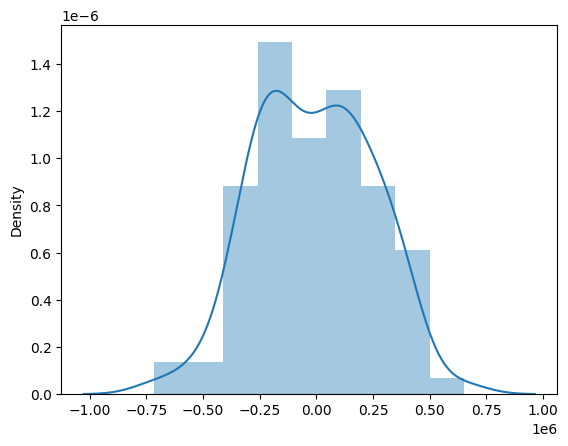

In [74]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

#### Trying the model in practice with new imaginary house

In [75]:
X.columns

Index(['Bedrooms', 'Bathrooms', 'SquareFeet', 'YearBuilt', 'GarageSpaces',
       'LotSize', 'CrimeRate', 'SchoolRating', 'Region_East', 'Region_North',
       'Region_South', 'Region_West'],
      dtype='object')

In [76]:
X.head(3)

,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,CrimeRate,SchoolRating,Region_East,Region_North,Region_South,Region_West
0,4,1.7,2847,1972,2,1.46,37.28,10,False,False,False,True
1,5,3.3,2740,1964,1,1.66,39.89,1,False,False,True,False
2,3,2.4,3163,1966,2,0.99,84.57,3,False,False,True,False


In [82]:
tester_row = {
    "Bedrooms": 1,
    "Bathrooms": 1,
    "SquareFeet": 120,
    "YearBuilt": 2008,
    "GarageSpaces": 1,
    "LotSize": 0.74,
    "CrimeRate": 0.29,
    "SchoolRating": 7,
    "Region_East": 1,
    "Region_North": 0,
    "Region_South": 0,
    "Region_West": 0
}

# In ein DataFrame umwandeln
tester_row = pd.DataFrame([tester_row])

# WICHTIG: Die gleichen Transformationen anwenden wie beim Training
tester_row_scaled = scaler.transform(tester_row)

# Vorhersage machen
result = training_model_1.predict(tester_row_scaled)[0][0]

print("Estimated house price with this example:")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Estimated house price with this example:
$435480.5


#### Conclusion

The results with the synthetic dataset of 5,000 samples generated by AI show a major improvement in model performance compared to the original dataset. The correlations in the synthetic data are stronger and more consistent, which gives the neural network clearer patterns to learn from. As a result, the evaluation metrics (very low MAE/RMSE and an R² close to 1.00) indicate that the model can now predict house prices with high accuracy. This highlights that the main limitation of the original U.S. housing dataset was its small size and weak feature relationships. By using AI-generated realistic data, the model was able to generalize much better.